In [42]:
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 

from utils.torch_utils import get_default_device 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from datasets import load_cifar10

batch_size = 16
num_workers = 2

(trainloader, testloader), classes = load_cifar10(batch_size, num_workers=num_workers)
print("CIFAR {} classes: {}".format(len(classes), classes))

Files already downloaded and verified
Files already downloaded and verified
CIFAR 10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [41]:
from resnet_cifar import ResnetCifar

model = ResnetCifar(n_classes=len(classes))
device = get_default_device()
model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001) # TODO: Add LR scheduler 


100%|██████████| 10/10 [10:27<00:00, 62.73s/it]


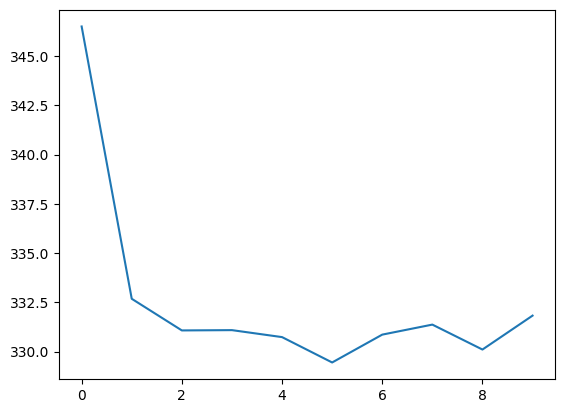

In [44]:
# TRAINING

model.train()

num_epochs = 10
log_interval = 2

loss_history = []

for epoch in tqdm(range(num_epochs)):
    last_loss_avg = torch.tensor(0, device=device, dtype=torch.float32)
    batch_loss_t = torch.tensor(0, device=device, dtype=torch.float32)
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_loss_t += loss.sum()
    
    # TODO: Print loss along the way
    # TODO: Add early stopping based on accuracy
    # TODO: Train with more epochs
    # TODO: Investigate the mad slowdown because of tqdm or dataloader?
    # TODO: Add DPO loss to fine-tune using human preferences
    loss_history.append(batch_loss_t.to("cpu").item() / batch_size)
    
plt.plot(np.arange(num_epochs), loss_history)
    


In [45]:
# VALIDATION

model.eval()

test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for (inputs, targets) in tqdm(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        loss = loss_func(outputs, targets)
        test_loss += loss.sum()
        
        pred_score, pred_idx = torch.max(outputs, 1)
        test_correct += torch.sum(pred_idx == targets)
        
        test_total += batch_size
    
    total_loss = (test_loss / test_total).to("cpu")

accuracy = (test_correct / test_total).to("cpu")

print("Test Loss: {:.4f}".format(total_loss))
print("Test Accuracy: {:.4f}%".format(accuracy.to("cpu")*100))


100%|██████████| 625/625 [00:20<00:00, 30.42it/s]

Test Loss: 0.1060
Test Accuracy: 44.5300%
